In [2]:
import torch
import torch.nn as nn
from functools import partial
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import math
from random import random
writer = SummaryWriter()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/root/miniconda3/envs/ebm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


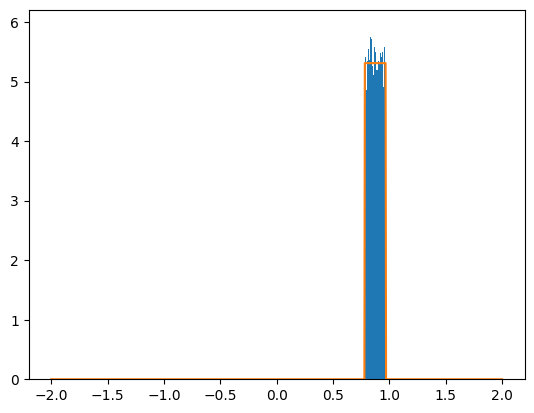

In [3]:
def density(mu, sigma):
    def f(x):
        return 1/(math.sqrt(2*math.pi)*sigma)*torch.exp(-(x-mu)**2/(2*sigma**2))
    return f

def rand_density(left, width):
    def f(x):
        return torch.where((x>left)&(x<left+width), 1/width, 0) 
    return f

x = torch.linspace(-2, 2, 1000)
left = random()*2-1
width = min(random(), 1-left)
f = rand_density(left, width)
sample = torch.rand(10000)*width+left
plt.hist(sample, bins=30, density=True)
plt.plot(x, f(x))

In [4]:
class MLP_cond(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, hidden_depth:int, output_dim:int, dropout:float) -> None:
        super().__init__()
        dropout_layer = partial(nn.Dropout, p=dropout)
        layers1 = [nn.Linear(input_dim, hidden_dim), nn.ReLU(), dropout_layer()]
        for _ in range(hidden_depth-1):
            layers1 += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), dropout_layer()]
        layers1.append(nn.Linear(hidden_dim, output_dim))
        self.layers1 = nn.Sequential(*layers1)
    def forward(self, x, cond):
        return self.layers1(torch.cat((x, cond), dim=-1))

In [5]:
def mse_loss(net, left, width):
    samples = torch.rand(10000, 1).to(device) * 4 - 2
    cond = torch.cat((left*torch.ones(10000, 1), width*torch.ones(10000, 1)), dim=-1).to(device)
    integral = torch.mean(torch.exp(-net(samples, cond)))*4
    x = torch.rand(10000, 1).to(device) * 4 - 2
    f = rand_density(left, width)
    ground_truth = f(x)
    pred = torch.exp(-net(x, cond))/integral
    return torch.mean((ground_truth-pred)**2)

In [6]:
def mse_loss(net, mu, sigma):
    samples = torch.rand(10000, 1).to(device) * 4 - 2
    cond = torch.cat((mu*torch.ones(10000, 1), sigma*torch.ones(10000, 1)), dim=-1).to(device)
    integral = torch.mean(torch.exp(-net(samples, cond)))*4
    x = torch.rand(10000, 1).to(device) * 4 - 2
    f = density(mu, sigma)
    ground_truth = f(x)
    pred = torch.exp(-net(x, cond))/integral
    return torch.mean((ground_truth-pred)**2)

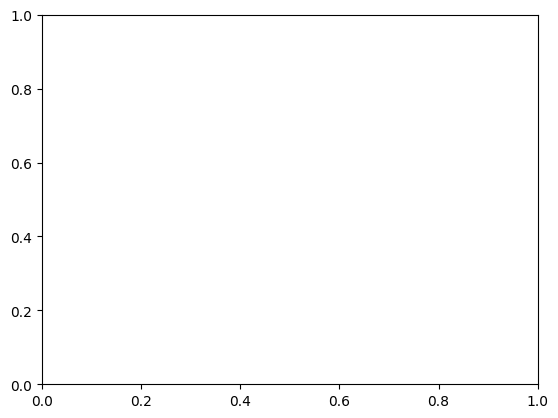

In [7]:
from tqdm import tqdm
from random import random

fig, ax = plt.subplots()

def reflact(tensor, down, up):
    t = tensor.clone()
    while ((down<t) & (t>up)).any():   
        t = torch.where(t<down, 2*down-t, t)
        t = torch.where(t>up, 2*up-t, t)
    return t

def energy_discrepancy(energy_net, x, margin, left, width, m_particles=16, t_noise=0.5, w_stable=1.0):
    device = x.device
    browniani = torch.randn_like(x).to(device) * t_noise
    brownianij = torch.randn(x.size(0), m_particles, *x.shape[1:]).to(device) * t_noise
    pert_data_origin = x.unsqueeze(1) + browniani.unsqueeze(1) + brownianij
    if margin=='clip':
        pert_data = torch.clip(pert_data_origin, -1, 1)
    elif margin=='reflact':
        pert_data = reflact(pert_data_origin, -1, 1)
    else:
        pert_data = pert_data_origin
    cond = torch.cat((left, width), -1)
    cond_repeat = cond.unsqueeze(1).repeat(1, m_particles, 1)
    pos_energy = energy_net(x=x, cond=cond)
    neg_energy = energy_net(x=pert_data, cond=cond_repeat)
    val = pos_energy - neg_energy.squeeze()
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)
    loss = val.logsumexp(dim=-1).mean()
    return loss, pos_energy.max(), neg_energy.max()

def energy_discrepancy_cond_train(energy_net, f, margin, m_particles=16, t_noise=0.5, w_stable=1.0, epochs=1000, batch_size=256):
    optimizer = torch.optim.Adam(energy_net.parameters(), lr=0.01)
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        left = torch.rand(batch_size, 1)*2-1
        width = torch.min(torch.rand(batch_size, 1), 1-left)
        f = rand_density(left, width)
        x = torch.rand(batch_size, 1)*width+left
        left, width, x = left.to(device), width.to(device), x.to(device)
        loss, _, _ = energy_discrepancy(energy_net, x, margin, left, width, m_particles, t_noise, w_stable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        energy_net.eval()
        test_loss = 0.0
        for _ in range(10):
            test_loss += mse_loss(energy_net, random()/2-0.25, (random()+1)/8)
        test_loss/=10
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/ED", loss.item(), epoch)
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/MSE", test_loss.item(), epoch)  
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/MSE_log", torch.log(test_loss).item(), epoch)  
        pbar.set_description('Epoch:{:4d},ED:{:.4f},MSE:{:.4f}'.format(epoch, loss.item(), test_loss.item()))
    x = torch.linspace(-2, 2, 1000)[..., None].to(device)
    left = random()*2-1
    width = min(random(), 1-left)
    f = rand_density(left, width)
    mu_repeat = left*torch.ones(1000, 1).to(device)
    sigma_repeat = width*torch.ones(1000, 1).to(device)
    samples = torch.rand(1000, 1).to(device) * 4 - 2
    integral = torch.mean(torch.exp(-energy_net(samples, torch.cat((mu_repeat, sigma_repeat), dim=-1)))).item()*4
    ax.cla()
    ax.plot(x.cpu().detach().numpy(), np.exp(-energy_net(x, torch.cat((mu_repeat, sigma_repeat), dim=-1)).cpu().detach().numpy())/integral, label='predict')
    ax.plot(x.cpu().detach().numpy(), f(x).cpu().detach().numpy(), label='ground_truth')
    ax.legend(loc='best')
    writer.add_figure(f"{margin}_t_noise_{t_noise}_w_{w_stable}/result",fig)

In [8]:
for margin in ['clip', 'reflact', None]:
    for t_noise in range(5):
        for w in [0.0, 0.1, 0.5, 1.0, 2.0]:
            net = MLP_cond(3, 512, 3, 1, 0.1).to(device)
            print("margin:{}, t_noise:{}, w:{}".format(margin, 2**t_noise*0.1, w))
            energy_discrepancy_cond_train(net, f, margin, m_particles=16, t_noise=2**t_noise*0.1, w_stable=w, epochs=5000, batch_size=512)

margin:clip, t_noise:0.1, w:0.0


Epoch:4999,ED:-9376675.0000,MSE:nan: 100%|██████████| 5000/5000 [02:15<00:00, 36.89it/s] 
/tmp/ipykernel_4340/2543618693.py:65: RuntimeWarning: overflow encountered in exp
  ax.plot(x.cpu().detach().numpy(), np.exp(-energy_net(x, torch.cat((mu_repeat, sigma_repeat), dim=-1)).cpu().detach().numpy())/integral, label='predict')
/tmp/ipykernel_4340/2543618693.py:65: RuntimeWarning: invalid value encountered in divide
  ax.plot(x.cpu().detach().numpy(), np.exp(-energy_net(x, torch.cat((mu_repeat, sigma_repeat), dim=-1)).cpu().detach().numpy())/integral, label='predict')


margin:clip, t_noise:0.1, w:0.1


Epoch:4999,ED:1.9505,MSE:nan: 100%|██████████| 5000/5000 [02:12<00:00, 37.82it/s]   


margin:clip, t_noise:0.1, w:0.5


Epoch:4999,ED:2.2285,MSE:0.8603: 100%|██████████| 5000/5000 [02:11<00:00, 38.13it/s]


margin:clip, t_noise:0.1, w:1.0


Epoch:4999,ED:2.3183,MSE:0.7777: 100%|██████████| 5000/5000 [02:13<00:00, 37.57it/s]


margin:clip, t_noise:0.1, w:2.0


Epoch:4999,ED:2.3610,MSE:0.8492: 100%|██████████| 5000/5000 [02:12<00:00, 37.81it/s]


margin:clip, t_noise:0.2, w:0.0


Epoch:4999,ED:-3817870336.0000,MSE:nan: 100%|██████████| 5000/5000 [02:11<00:00, 37.90it/s] 


margin:clip, t_noise:0.2, w:0.1


Epoch:4999,ED:1.6076,MSE:0.7386: 100%|██████████| 5000/5000 [02:13<00:00, 37.57it/s]


margin:clip, t_noise:0.2, w:0.5


Epoch:4999,ED:1.6648,MSE:0.7861: 100%|██████████| 5000/5000 [02:13<00:00, 37.50it/s]


margin:clip, t_noise:0.2, w:1.0


Epoch:4999,ED:1.8321,MSE:0.7939: 100%|██████████| 5000/5000 [02:12<00:00, 37.76it/s]


margin:clip, t_noise:0.2, w:2.0


Epoch:4999,ED:2.1197,MSE:nan: 100%|██████████| 5000/5000 [02:11<00:00, 37.95it/s]   


margin:clip, t_noise:0.4, w:0.0


Epoch:4999,ED:-320556695552.0000,MSE:nan: 100%|██████████| 5000/5000 [02:12<00:00, 37.72it/s]


margin:clip, t_noise:0.4, w:0.1


Epoch:4999,ED:0.9167,MSE:0.7930: 100%|██████████| 5000/5000 [02:11<00:00, 37.94it/s]


margin:clip, t_noise:0.4, w:0.5


Epoch:4999,ED:1.3109,MSE:nan: 100%|██████████| 5000/5000 [02:15<00:00, 36.79it/s]   


margin:clip, t_noise:0.4, w:1.0


Epoch:4999,ED:1.4866,MSE:nan: 100%|██████████| 5000/5000 [02:11<00:00, 37.91it/s]   


margin:clip, t_noise:0.4, w:2.0


Epoch:4999,ED:1.6668,MSE:0.8252: 100%|██████████| 5000/5000 [02:17<00:00, 36.37it/s]


margin:clip, t_noise:0.8, w:0.0


Epoch:4999,ED:-6065854349312.0000,MSE:nan: 100%|██████████| 5000/5000 [02:10<00:00, 38.23it/s]


margin:clip, t_noise:0.8, w:0.1


Epoch:4999,ED:0.1500,MSE:0.9150: 100%|██████████| 5000/5000 [02:14<00:00, 37.27it/s] 


margin:clip, t_noise:0.8, w:0.5


Epoch:4999,ED:0.8183,MSE:0.7760: 100%|██████████| 5000/5000 [02:13<00:00, 37.42it/s]


margin:clip, t_noise:0.8, w:1.0


Epoch:4999,ED:1.0066,MSE:0.8284: 100%|██████████| 5000/5000 [02:14<00:00, 37.20it/s]


margin:clip, t_noise:0.8, w:2.0


Epoch:4999,ED:1.3978,MSE:nan: 100%|██████████| 5000/5000 [02:13<00:00, 37.49it/s]   


margin:clip, t_noise:1.6, w:0.0


Epoch:4999,ED:-47764989804544.0000,MSE:nan: 100%|██████████| 5000/5000 [02:11<00:00, 37.95it/s]


margin:clip, t_noise:1.6, w:0.1


Epoch:4999,ED:-0.4395,MSE:0.8360: 100%|██████████| 5000/5000 [02:14<00:00, 37.22it/s]


margin:clip, t_noise:1.6, w:0.5


Epoch:4999,ED:0.2497,MSE:0.8081: 100%|██████████| 5000/5000 [02:13<00:00, 37.51it/s]


margin:clip, t_noise:1.6, w:1.0


Epoch:4999,ED:0.6965,MSE:0.7905: 100%|██████████| 5000/5000 [02:12<00:00, 37.69it/s]


margin:clip, t_noise:1.6, w:2.0


Epoch:4999,ED:1.1611,MSE:0.6990: 100%|██████████| 5000/5000 [02:12<00:00, 37.63it/s]


margin:reflact, t_noise:0.1, w:0.0


Epoch:4999,ED:-13927326.0000,MSE:nan: 100%|██████████| 5000/5000 [02:14<00:00, 37.22it/s]


margin:reflact, t_noise:0.1, w:0.1


Epoch:4999,ED:2.0614,MSE:0.8035: 100%|██████████| 5000/5000 [02:11<00:00, 38.00it/s]


margin:reflact, t_noise:0.1, w:0.5


Epoch:4999,ED:2.2235,MSE:0.8714: 100%|██████████| 5000/5000 [02:17<00:00, 36.39it/s]


margin:reflact, t_noise:0.1, w:1.0


Epoch:4999,ED:2.2815,MSE:nan: 100%|██████████| 5000/5000 [02:14<00:00, 37.27it/s]   


margin:reflact, t_noise:0.1, w:2.0


Epoch:4999,ED:2.4542,MSE:0.8025: 100%|██████████| 5000/5000 [02:14<00:00, 37.16it/s]


margin:reflact, t_noise:0.2, w:0.0


Epoch:4999,ED:-16329254912.0000,MSE:nan: 100%|██████████| 5000/5000 [02:13<00:00, 37.41it/s]


margin:reflact, t_noise:0.2, w:0.1


Epoch:4999,ED:1.6523,MSE:0.5881: 100%|██████████| 5000/5000 [02:16<00:00, 36.61it/s]


margin:reflact, t_noise:0.2, w:0.5


Epoch:4999,ED:1.8970,MSE:0.8731: 100%|██████████| 5000/5000 [02:14<00:00, 37.22it/s]


margin:reflact, t_noise:0.2, w:1.0


Epoch:1533,ED:1.9661,MSE:0.8734:  31%|███       | 1534/5000 [00:41<01:34, 36.63it/s]


KeyboardInterrupt: 